In [1]:
# Notebook to simulate diffusion equation for the MHD systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm.auto import tqdm

C:\Users\cdipt\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Solving Equations iteratively
# The differential equation in Br
def Eqn_Br(Br, Bphi, dr, eta, d_t, r, V_r, V_z, h, alpha):
    """
    Br: np.array(n,): Stores the vale of Br at time step t for all r
    B_phi:  np.array(n,): Stores the vale of B_phi at time step t for all r
    dr: np.array(n,):Grid Spacing
    eta: (float) diffusivity
    """
    diag = ((-V_r/r + V_z/(4*h) - eta/(r**2) -(2*eta)/(dr**2) - (eta*np.pi**2)/(4*h**2))[None,:]*np.eye(B_r.shape[0]))

    upper_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    upper_diag[:-1,1:]  = ((-V_r/(2*dr) + eta/(dr**2) + eta/(2*r*dr))[None,:]*np.eye(B_r.shape[0]))[1:,1:] 

    lower_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    lower_diag[1:,:-1] = ((V_r/(2*dr)+ eta/(dr**2) -eta/(2*r*dr))[None,:]*np.eye(B_r.shape[0]))[:-1,:-1]

    diag2 = ((2*alpha)/(np.pi*h)[None,:]*np.eye(B_phi.shape[0]))
    
    mat1 = diag + upper_diag + lower_diag
    mat2 = diag2.copy()
    k = (mat1@B_r[:,None])[:,0] + (mat2@B_phi[:,None])[:,0]
    k[[0,-1]] = 0
    return k*d_t

# Full Eqn in Bphi
def Eqn_Bphi(Br,Bphi,dr,eta, d_t, r, V_r, V_z, h, alpha, omega):
    diag =  (-np.gradient(V_r)/(dr) - V_z/(4*h) -1*(2*eta)/(dr**2) - eta/(r**2) - (eta*np.pi**2)/(4*h**2))[None,:]*np.eye(B_phi.shape[0])
    
    upper_diag = np.zeros((B_phi.shape[0],B_phi.shape[0])) 
    upper_diag[:-1,1:]  = ((-V_r/(2*dr) + eta/(dr**2) + eta/(2*r*dr))[None,:]*np.eye(B_phi.shape[0]))[1:,1:] 

    lower_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    lower_diag[1:,:-1] = (( V_r/(2*dr) + eta/(dr**2) - eta/(2*r*dr))[None,:]*np.eye(B_phi.shape[0]))[:-1,:-1]
                                                                                       
    diag2 = (-r*(np.gradient(omega)/dr) + (2*alpha)/(np.pi*h))[None,:]*np.eye(B_r.shape[0])
    
    mat1 = diag + upper_diag + lower_diag
    mat2 = diag2.copy()
    k = (mat1@B_phi[:,None])[:,0] + (mat2@B_r[:,None])[:,0]
    k[[0,-1]] = 0
    return k*d_t
                                                                                       
# Runge Kutta Step
def runge_kutta_step(Br, Bphi, dt, eta, r, dr, V_r, V_z, h, alpha, omega):
    
    k1_r = dt *  Eqn_Br(Br, Bphi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k1_phi = dt *  Eqn_Bphi(Br, Bphi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k2_r = dt *  Eqn_Br(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k2_phi = dt *  Eqn_Bphi(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k3_r = dt *  Eqn_Br(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k3_phi = dt *  Eqn_Bphi(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    k4_r = dt *  Eqn_Br(Br + k3_r, Bphi + k3_phi, dr, eta, dt, r, V_r, V_z, h, alpha)
    k4_phi = dt *  Eqn_Bphi(Br + k3_r, Bphi + k3_phi, dr, eta, dt, r, V_r, V_z, h, alpha, omega)

    return (Br + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6, Bphi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6)

In [3]:
def B_r_f(r):
    return -(r-5)**(2)  + 25

def B_phi_f(r):
    return (r - 5)**(2) - 25

def alpha_f(r):
    alpha_0 = 10.0
    return np.ones_like(r)*alpha_0

def omega_f(r):
    return 10/np.sqrt(1+(r/4)**2)


def V_r_f(r):
    return r*0
def V_z_f(r):
    return r*0


In [4]:

h_val = 0.1
eta_m = 0.01
eta_t = 0.2

r_min = 1e-8
t_min = 0

r_max = 10
t_max = 10

d_r = 0.01
d_t = 0.01
h_val = 0.1
eta_m =0.01
eta_t = 0

r = np.arange(r_min, r_max, d_r) # radial array for uniform radial steps
dr = np.diff(r, prepend=0)    # radial step array

h = h_val* np.ones_like(r) # constant scale height h

t = np.arange(t_min, t_max, d_t) # time array for uniform time steps
dt = np.diff(t, prepend=0)     # time step array
d_t = dt[1]
eta = eta_m + eta_t # total diffusivity

omega = omega_f(r)
alpha = alpha_f(r)
V_r = V_r_f(r)
V_z = V_z_f(r)

q_omega = - r * np.gradient(omega)/dr  # q = - r d omega / dr
D = - alpha[0]* q_omega * h[2]**(3) / eta**2    # D = - alpha q / 2 omega
D = np.average(D)

B_r = B_r_f(r)
B_phi = B_phi_f(r)

B_r_evolution = []
B_phi_evolution = []
time = []
time_evol = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi

r_val = 5

r_index = np.where(np.min(np.abs(r - r_val)) < 1e-5)[0][0]
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%20 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
        time_evol.append(t_min + i*d_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t,r=r, dr=dr, dt=time_step, omega=omega, alpha=alpha, V_r=V_r, V_z=V_z, h=h, eta=eta)



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Initial Conditions')

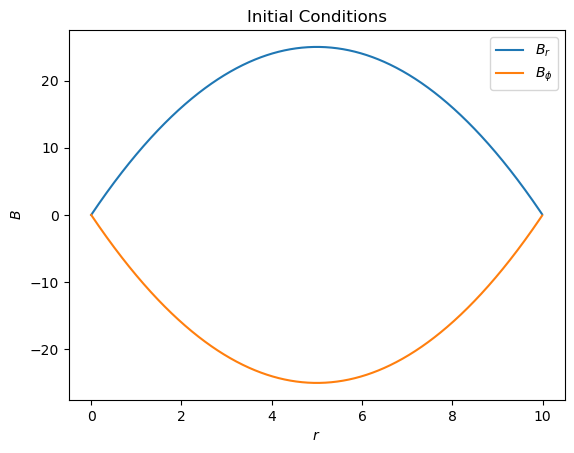

In [12]:
plt.plot(r, B_r_f(r), label=r"$B_r$")
plt.plot(r, B_phi_f(r), label=r"$B_{\phi}$")
plt.xlabel(r"$r$")
plt.ylabel(r"$B$")
plt.legend()
plt.title("Initial Conditions")

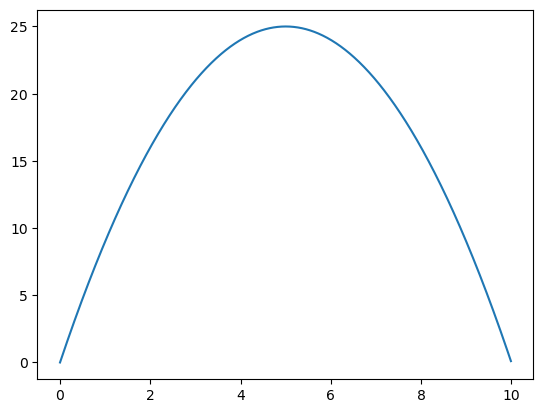

In [12]:
plt.plot(r, B_r_evolution[0,:], label=f"B_r_{i}")
# plt.plot(r, B_r_evolution[1,:], label=f"B_r_{i}")

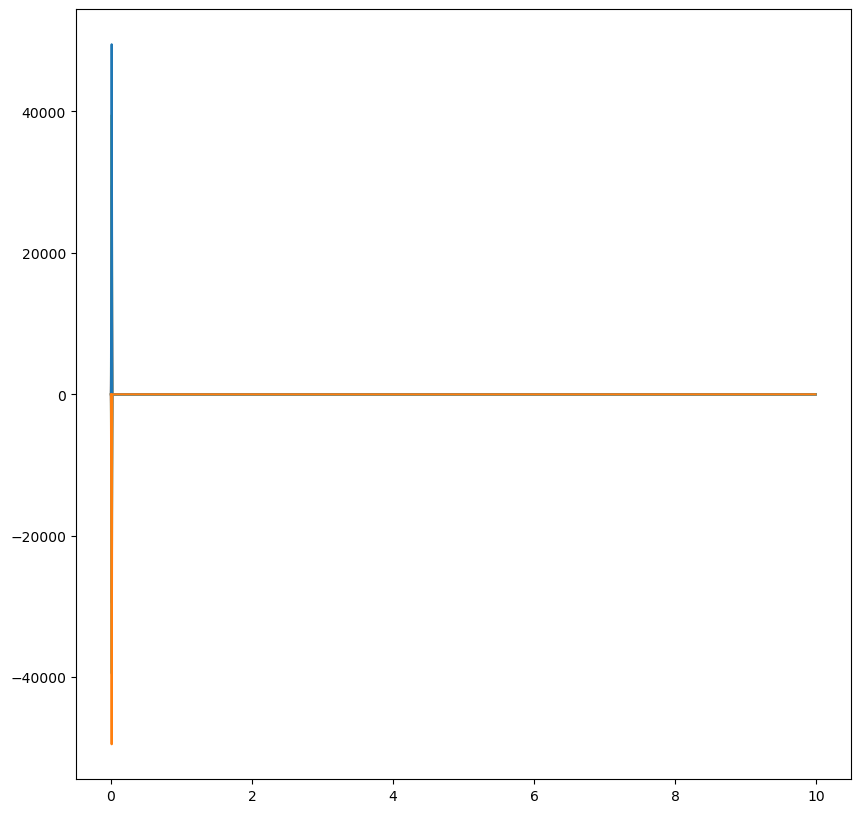

In [8]:
B_r_evolution = np.array(B_r_evolution)
B_phi_evolution = np.array(B_phi_evolution)

plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i,:], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i,:], label=f"Bphi_{i}")

In [35]:
B_phi(r)

TypeError: 'numpy.ndarray' object is not callable

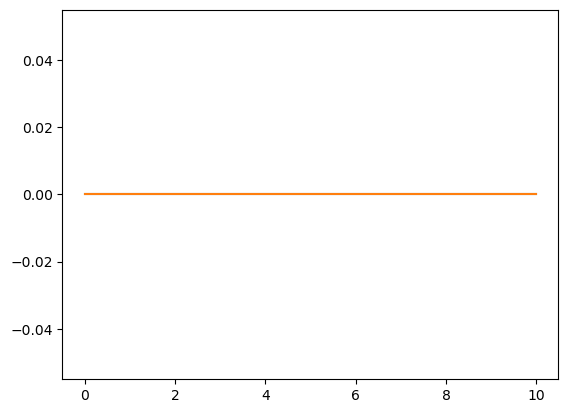

In [33]:
plt.plot(r, B_r, label=r"$B_r$")
plt.plot(r, B_phi, label=r"$B_{\phi}$")

In [27]:
np.min(r_val)

5.001

In [28]:
np.min(np.abs(r - r_val))

8.881784197001252e-16

In [71]:
q_omega = - r * np.gradient(omega)/dr  # q = - r d omega / dr

ValueError: operands could not be broadcast together with shapes (1000,) (0,) 

In [73]:
omega

0

In [177]:
d_t = 0.01

r_min = 0.01
r_max = 10


t_min = 0
t_max = 2

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max+d_r, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0) 

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

# Time-stepping scheme using Runge-Kutta
B_r_evolution = []
B_phi_evolution = []
time = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi
r_val = 5 
r_index = np.where(r == r_val)[0][0]
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%50 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t, dt=time_step)

  0%|          | 0/199 [00:00<?, ?it/s]

In [123]:
r.shape

(999,)

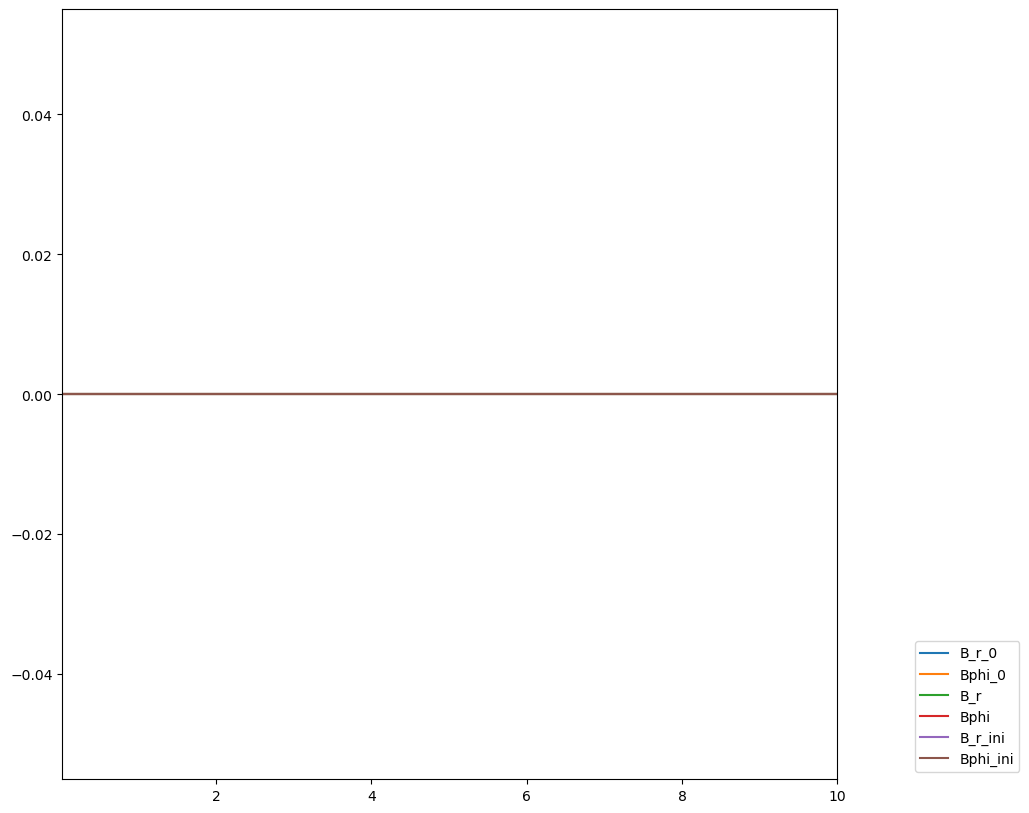

In [30]:
plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

plt.plot(r, B_r_t, label="B_r")
plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r, label="B_r_ini")
plt.plot(r, B_phi, label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlim(0.02,10)
plt.show()

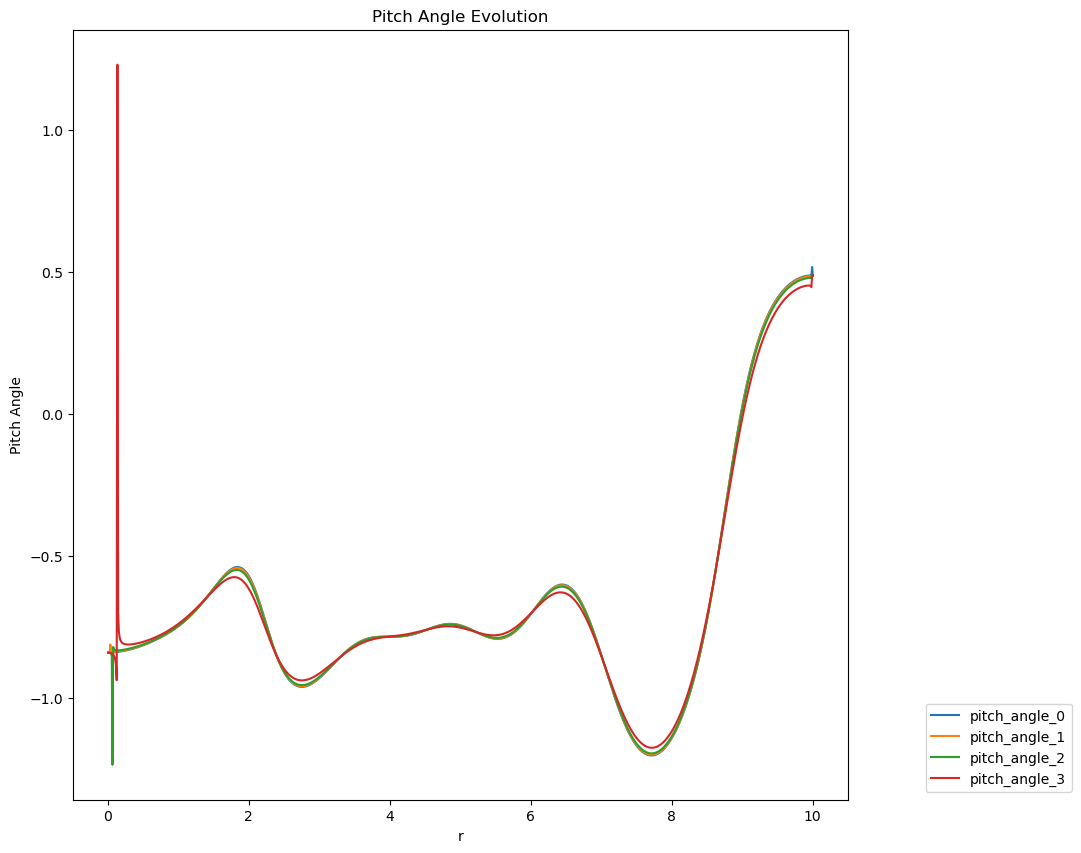

In [179]:
def pitch_angle(Br, Bphi):
    return np.arctan(Br/Bphi)

plt.figure(figsize=(10, 10))
plt.title("Pitch Angle Evolution")
for i in range(len(B_r_evolution)):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
plt.legend(loc=(1.1,0.01))